# Street Crime in Baltimore: Narative Analytics and Experimentation
By: Katie Peterson

## Introduction
Baltimore is a city that is infamous for high crime rates, being named the 7th most dangerous city in the United States in 2015, to having a record-breaking number of homicides per capita in 2017. This high rate of crime threatens economic development.  Reduction of crime in Baltimore is important to improve the quality of life for citizens, increase real estate values, and to boost the local economy. 

In an effort to try to reduce crime in Baltimore, data was taken from the [Baltimore Police Department](https://www.kaggle.com/sohier/crime-in-baltimore) which represents victim based crime data.  This data is important to analyze to understand the city crime patterns and to implement efforts to stop crimes from happening in the first place. My initial analysis will analyze data for the entire city from 2012 to 2017.  I will identify patterns in order to zoom in on actions that could potentially impact the data, and then design an A/B test to identify the impact of that action on crime.

## Data Set Analysis
First, I will inspect the data for patterns and hot spot areas of crime.

In [1]:
# Necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from datetime import datetime

In [2]:
# Import data
bpd = pd.read_csv('BPD_Part_1_Victim_Based_Crime_Data.csv', dtype={'Premise':str})
bpd.head()

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,Total Incidents
0,09/02/2017,23:30:00,3JK,4200 AUDREY AVE,ROBBERY - RESIDENCE,I,KNIFE,913.0,SOUTHERN,Brooklyn,-76.60541,39.22951,"(39.2295100000, -76.6054100000)",ROW/TOWNHO,1
1,09/02/2017,23:00:00,7A,800 NEWINGTON AVE,AUTO THEFT,O,NaN,133.0,CENTRAL,Reservoir Hill,-76.63217,39.31360,"(39.3136000000, -76.6321700000)",STREET,1
2,09/02/2017,22:53:00,9S,600 RADNOR AV,SHOOTING,Outside,FIREARM,524.0,NORTHERN,Winston-Govans,-76.60697,39.34768,"(39.3476800000, -76.6069700000)",Street,1
3,09/02/2017,22:50:00,4C,1800 RAMSAY ST,AGG. ASSAULT,I,OTHER,934.0,SOUTHERN,Carrollton Ridge,-76.64526,39.28315,"(39.2831500000, -76.6452600000)",ROW/TOWNHO,1
4,09/02/2017,22:31:00,4E,100 LIGHT ST,COMMON ASSAULT,O,HANDS,113.0,CENTRAL,Downtown West,-76.61365,39.28756,"(39.2875600000, -76.6136500000)",STREET,1


In [3]:
# Identify where entries are null
bpd.isnull().sum()

CrimeDate               0
CrimeTime               0
CrimeCode               0
Location             2207
Description             0
Inside/Outside      10279
Weapon             180952
Post                  224
District               80
Neighborhood         2740
Longitude            2204
Latitude             2204
Location 1           2204
Premise             10757
Total Incidents         0
dtype: int64

It appears that the date, time, crime code, and crime descriptions are required for all entries.  Additionally, all entries in the Total Incidents column are equal to 1. Some of the columns need to be cleaned up for analysis, for example Inside/Outside, and Premise. 

In [4]:
#change Inside/Outside column name for ease of use
bpd.columns = ['CrimeDate', 'CrimeTime', 'CrimeCode', 'Location', 'Description',
       'InsideOutside', 'Weapon', 'Post', 'District', 'Neighborhood',
       'Longitude', 'Latitude', 'Location 1', 'Premise', 'Total Incidents']

To facilitate analysis by year, month, and hour of day, I will break the CrimeDate and CrimeTime columns down into their respective parts.

In [5]:
# Slicing for year, month and hour
bpd['year'] = bpd.CrimeDate.map(lambda x: x[6:])
bpd['month'] = bpd.CrimeDate.map(lambda x: x[:2])
bpd['day'] = bpd.CrimeDate.map(lambda x: x[3:5])
bpd['hour'] = bpd.CrimeTime.map(lambda x: x[:2])
bpd.head()

,CrimeDate,CrimeTime,CrimeCode,Location,Description,InsideOutside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,Total Incidents,year,month,day,hour
0,09/02/2017,23:30:00,3JK,4200 AUDREY AVE,ROBBERY - RESIDENCE,I,KNIFE,913.0,SOUTHERN,Brooklyn,-76.60541,39.22951,"(39.2295100000, -76.6054100000)",ROW/TOWNHO,1,2017,09,02,23
1,09/02/2017,23:00:00,7A,800 NEWINGTON AVE,AUTO THEFT,O,NaN,133.0,CENTRAL,Reservoir Hill,-76.63217,39.31360,"(39.3136000000, -76.6321700000)",STREET,1,2017,09,02,23
2,09/02/2017,22:53:00,9S,600 RADNOR AV,SHOOTING,Outside,FIREARM,524.0,NORTHERN,Winston-Govans,-76.60697,39.34768,"(39.3476800000, -76.6069700000)",Street,1,2017,09,02,22
3,09/02/2017,22:50:00,4C,1800 RAMSAY ST,AGG. ASSAULT,I,OTHER,934.0,SOUTHERN,Carrollton Ridge,-76.64526,39.28315,"(39.2831500000, -76.6452600000)",ROW/TOWNHO,1,2017,09,02,22
4,09/02/2017,22:31:00,4E,100 LIGHT ST,COMMON ASSAULT,O,HANDS,113.0,CENTRAL,Downtown West,-76.61365,39.28756,"(39.2875600000, -76.6136500000)",STREET,1,2017,09,02,22


Now let's take a look at the locations of the crimes.

In [6]:
#describing locations of crimes
bpd['InsideOutside'].value_counts()

I          131999
O          129782
Outside      3837
Inside        632
Name: InsideOutside, dtype: int64

Because there are two different labels for inside and outside, I will clean and combine these labels to I and O.

In [7]:
# Combining labels of I with inside and O with outside
bpd['InsideOutside']  = bpd.InsideOutside.replace('Inside', 'I')
bpd['InsideOutside']  = bpd.InsideOutside.replace('Outside', 'O')
bpd['InsideOutside'].value_counts()

O    133619
I    132631
Name: InsideOutside, dtype: int64

Now let's inspect the premise column, strip out extra white space, and capitalize the result to standardize the entries, then inspect the counts of each type of premise.

In [8]:
# Cleaning up premise by stripping and turning into upper cases
bpd['Premise'] = bpd['Premise'].map(lambda x: x.strip().upper() if type(x) is str else x)
premise_count = bpd.Premise.value_counts().head()
premise_count

STREET        103802
ROW/TOWNHO     60502
PARKING LO     12176
APT/CONDO      12002
OTHER - IN     11459
Name: Premise, dtype: int64

Great, now let's see those visually through a count plot of the number of crimes versus the premise of the crimes.

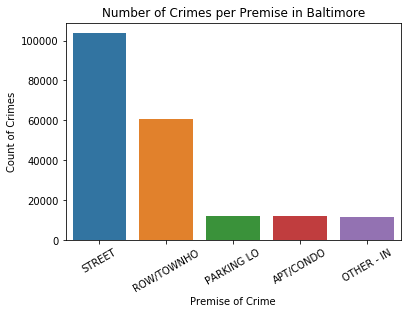

In [9]:
# Graphing total crimes by premise
g = sns.barplot(x=premise_count.index, y=premise_count)
plt.xlabel('Premise of Crime')
plt.xticks(rotation=30)
plt.ylabel('Count of Crimes')
plt.title('Number of Crimes per Premise in Baltimore')
plt.show()

The premise that has the highest occurrence of crimes (approximately double the second highest) is the street.  To further investigate this, I will break down the data frame into just street crimes and find the most common type of crime in the streets and which neighborhood has the highest occurrence of street crimes.

In [10]:
# Creating data frame for only street crimes
street_crime = bpd[bpd.Premise == 'STREET'].reset_index(drop=True)

# Street crimes broken down by type of crime
street_crime.Description.value_counts()

LARCENY FROM AUTO       25817
AUTO THEFT              19335
LARCENY                 15246
ROBBERY - STREET        13027
COMMON ASSAULT          13017
AGG. ASSAULT            11504
SHOOTING                 2049
ROBBERY - CARJACKING     1140
HOMICIDE                  834
ASSAULT BY THREAT         601
ARSON                     467
BURGLARY                  336
ROBBERY - COMMERCIAL      207
RAPE                      187
ROBBERY - RESIDENCE        35
Name: Description, dtype: int64

It looks like larceny from auto, auto theft, larceny, street robbery, common assault, and aggravated assault are the most common types of street crimes.  For the most part, these seem like crimes of opportunity where a car gets broken into and something gets stolen.  This could be a type of crime to target for experimentation.

Next, let's take a look at where street crimes happen most often so we can find different locations to complete our tests.

In [11]:
# Street crimes broken down by district
street_crime.District.value_counts()

SOUTHEASTERN    15988
NORTHEASTERN    14000
CENTRAL         13285
SOUTHERN        11497
NORTHERN        10579
EASTERN          9763
NORTHWESTERN     9667
WESTERN          9649
SOUTHWESTERN     9344
Name: District, dtype: int64

According to the data, the Southeastern and Northeastern districts have the most crime, and approximately and same amount of street crime.  Since these districts are so large, let's take a look at the individual neighborhoods to determine which neighborhoods have the highest crime.

In [12]:
# Street crimes broken down by neighborhood
street_crime.Neighborhood.value_counts().head(10)

Downtown                     3809
Belair-Edison                1964
Sandtown-Winchester          1823
Frankford                    1697
Canton                       1666
Fells Point                  1643
Brooklyn                     1601
Patterson Park Neighborho    1601
Washington Village/Pigtow    1281
Upton                        1263
Name: Neighborhood, dtype: int64

Downtown Baltimore has the highest crime rate out of all of the neighborhoods, followed by Belair-Edison and Sandtown-Winchester.  This might help us narrow down locations for experimentation.  Since I already identified that the Southeastern and Northeastern have the highest crime, let's check the neighborhoods that are in these districts.

In [13]:
print('Southeastern Neighborhood Crime:\n', 
      street_crime[street_crime['District'] == 'SOUTHEASTERN']['Neighborhood'].value_counts().head(5)) 
print('\nNortheastern Neighborhood Crime:\n', 
      street_crime[street_crime['District'] == 'NORTHEASTERN']['Neighborhood'].value_counts().head(5))

Southeastern Neighborhood Crime:
 Canton                       1666
Fells Point                  1643
Patterson Park Neighborho    1601
McElderry Park               1137
Ellwood Park/Monument         921
Name: Neighborhood, dtype: int64

Northeastern Neighborhood Crime:
 Belair-Edison                1964
Frankford                    1697
Coldstream Homestead Mont    1257
Hamilton Hills                892
Ednor Gardens-Lakeside        687
Name: Neighborhood, dtype: int64


According to the data, the Canton, Fells Point, and Patterson Park neighborhood have the highest incidence of street crimes in the Southeastern district.  In the Northeastern district, the Belair-Edison, Frankford, and Coldstream Homestead Mont neighborhoods have high rates of street crime.   Now that we've analyzed the overall data, let's see what the trend in number of crimes is over the years.

In [14]:
# Identify pattern of street crimes over the past years
street_crime_year = street_crime.year.value_counts().sort_index(axis=0, ascending=True)
print(street_crime_year)

2012    17381
2013    17964
2014    17458
2015    20191
2016    19906
2017    10902
Name: year, dtype: int64


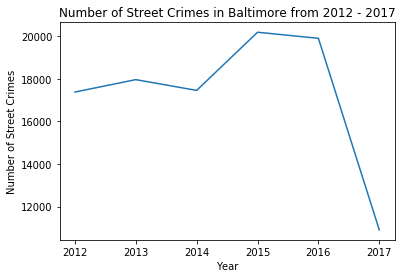

In [15]:
# Plotting street crimes by year
plt.plot(street_crime_year.index, street_crime_year)
plt.xlabel('Year')
plt.ylabel('Number of Street Crimes')
plt.title('Number of Street Crimes in Baltimore from 2012 - 2017')
plt.show()

While it appears that there is a large decrease in street crime in 2017, this data set only contains data for Jan 1, 2017 through September 3, 2017.  Given that, the data indicates that 2015 and 2016 had a higher number of crimes than in the previous three years.  To identify if current trends are similar to those of 2015 and 2016, I will analyze that data specifically.

First, I will separate out the data for each year and month for each year.

In [16]:
# Creating data frame for street crimes in 2017
bpd2017_street = street_crime[street_crime['year'] == '2017']
# Counting street crimes by month  
bpd2017_s_month = bpd2017_street.month.value_counts().sort_index(axis=0, ascending=True)

In [17]:
# Creating data frame for street crimes in 2016
bpd2016_street = street_crime[street_crime['year'] == '2016']
# Counting street crimes by month  
bpd2016_s_month = bpd2016_street.month.value_counts().sort_index(axis=0, ascending=True)

In [18]:
# Creating data frame for street crimes in 2015
bpd2015_street = street_crime[street_crime['year'] == '2015']
# Counting street crimes by month  
bpd2015_s_month = bpd2015_street.month.value_counts().sort_index(axis=0, ascending=True)

Now, I will graph this data to identify patterns and trends.

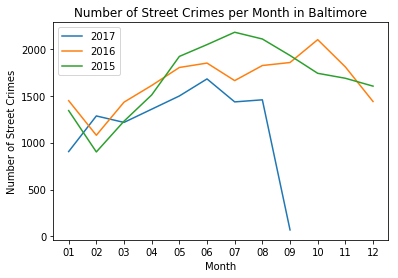

In [19]:
# Plotting monthly data of street crimes
plt.plot(bpd2017_s_month.index, bpd2017_s_month, label='2017')
plt.plot(bpd2016_s_month.index, bpd2016_s_month, label='2016')
plt.plot(bpd2015_s_month.index, bpd2015_s_month, label='2015')
plt.xlabel('Month')
plt.ylabel('Number of Street Crimes')
plt.title('Number of Street Crimes per Month in Baltimore')
plt.legend()
plt.show()

It appears that 2015 and 2016 follow the same trends for January through June, with a higher number of crimes in 2016 until May 2016.  After May 2015 there is a spike in number of street crimes that continues until approximately October.  Note that April through July of 2015 were the protests and riots following Freddie Gray's death.  This explains the spike in crimes in those months of 2015. 

Overall, the patterns of crimes match, moreso for 2016 and 2017, with, in general, 2017 having fewer crimes than 2016.

#### Type and Time of Crime
According to the data, 2016 and 2017 are following similar trends to one another, therefore in order to identify current trends, I will focus my analysis on 2017 crimes.  In particular, I want to know which type of street crimes are most common, and when they occur.

In [20]:
# Identifing top types of street crimes in 2017
bpd2017_street.Description.value_counts()

LARCENY FROM AUTO       2048
AUTO THEFT              1854
LARCENY                 1643
ROBBERY - STREET        1538
AGG. ASSAULT            1452
COMMON ASSAULT          1314
SHOOTING                 370
ROBBERY - CARJACKING     237
HOMICIDE                 167
BURGLARY                  89
ASSAULT BY THREAT         70
ARSON                     49
ROBBERY - COMMERCIAL      43
RAPE                      16
ROBBERY - RESIDENCE       12
Name: Description, dtype: int64

Alright, it looks like the same types of crimes were common in 2017 as in the overall data - larceny from auto, auto theft, larceny, street robbery, and assault. 

Now I want to know when during the day the top types of crime occur, so I will pull out the types of crime and then plot the number of crimes by hour for each type of crime.

In [21]:
# Pulling data frames for the six top types of street crimes
sc2017_lar = bpd2017_street[bpd2017_street['Description'] == 'LARCENY']
# Counting occurrences of crime by hour
sc2017_lar_hour = sc2017_lar.hour.value_counts().sort_index(axis=0, ascending=True)

sc2017_lfa = bpd2017_street[bpd2017_street['Description'] == 'LARCENY FROM AUTO']
sc2017_lfa_hour = sc2017_lfa.hour.value_counts().sort_index(axis=0, ascending=True)

sc2017_at = bpd2017_street[bpd2017_street['Description'] == 'AUTO THEFT']
sc2017_at_hour = sc2017_at.hour.value_counts().sort_index(axis=0, ascending=True)

sc2017_rs = bpd2017_street[bpd2017_street['Description'] == 'ROBBERY - STREET']
sc2017_rs_hour = sc2017_rs.hour.value_counts().sort_index(axis=0, ascending=True)

sc2017_agg = bpd2017_street[bpd2017_street['Description'] == 'AGG. ASSAULT']
sc2017_agg_hour = sc2017_agg.hour.value_counts().sort_index(axis=0, ascending=True)

sc2017_ca = bpd2017_street[bpd2017_street['Description'] == 'COMMON ASSAULT']
sc2017_ca_hour = sc2017_ca.hour.value_counts().sort_index(axis=0, ascending=True)

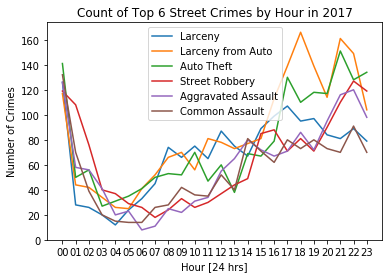

In [22]:
# Plotting top six street crimes by hour
plt.plot(sc2017_lar_hour.index, sc2017_lar_hour, label='Larceny')
plt.plot(sc2017_lfa_hour.index, sc2017_lfa_hour, label='Larceny from Auto')
plt.plot(sc2017_at_hour.index, sc2017_at_hour, label='Auto Theft')
plt.plot(sc2017_rs_hour.index, sc2017_rs_hour, label='Street Robbery')
plt.plot(sc2017_agg_hour.index, sc2017_agg_hour, label='Aggravated Assault')
plt.plot(sc2017_ca_hour.index, sc2017_ca_hour, label='Common Assault')
plt.xlabel('Hour [24 hrs]')
plt.ylabel('Number of Crimes')
plt.title('Count of Top 6 Street Crimes by Hour in 2017')
plt.legend()
plt.show()

According to the data, most street crime occurs between 16:00 (4 pm) and 00:00 (midnight), with spikes at 6 pm, 10 pm, and midnight.  This could help us identify times in which more patrol needs to be on duty and/or when people need to be more vigilant. 

#### Districts
I now want to see which districts had the highest street crimes in 2017, again to narrow down locations for possible crime prevention strategies and to confirm that the pattern in 2017 matches that of the overall data.

In [23]:
# All 2017 crimes broken down by district
bpd2017_street.District.value_counts().head()

SOUTHEASTERN    1525
NORTHEASTERN    1505
SOUTHERN        1287
CENTRAL         1241
EASTERN         1179
Name: District, dtype: int64

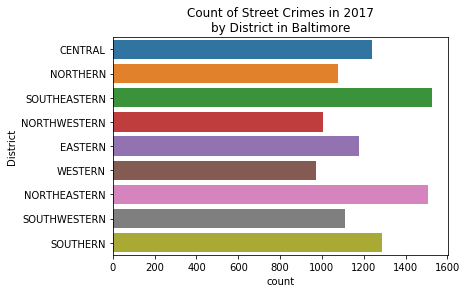

In [24]:
# Plotting street crimes by district
g = sns.countplot(y='District', data=bpd2017_street)
plt.title('Count of Street Crimes in 2017\nby District in Baltimore')
plt.show()

The highest number of street crimes in 2017 occur in the Southeastern and Northeastern districts, just as in the overall data.  These would be the best areas to focus on for crime prevention, especially since the counts of crimes in the two neighborhoods are so similar. 

#### Analysis Highlights
The majority of crimes in Baltimore occur on the streets, which are mostly larceny from auto, larceny, and auto theft.  These occurred primariliy between 4 pm and midnight and in the Southeastern and Northeastern districts.

## Experimental Hypothesis
If larceny from auto prevention strategies are employed in a district, then street crime in that district will decrease. 

## Methodology

### A/B Test
1. The two versions of this test will be the Southeastern and Northeastern districts.  Both districts have similar numbers of street crimes occurring in each district, and based on this data, are very similar districts.  See figures below demonstrating similarities in number of crimes in 2017 by month in the two regions. 

2. The Southeastern district will be our "test region", and the Northeastern district will be our "control region".  In the test region, we will employ auto theft prevention strategies, such as billboards and electronic signs with theft prevention tips.  The control region will continue to exist as normal.  

3. The key metric used to assess this hypothesis will be the instances of street crime, specifically a t-test of distributions of the daily average counts of street crime numbers in the districts.  

4. We might also detect a change in the number of non-street crimes in that district as a result of the change.

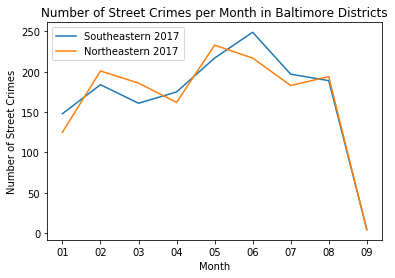

In [25]:
# Confirming that the counts of street crimes in the two districts are similar for the two months.

# Isolating crimes from Southeastern and Northeastern districts to ensure equivalent samples 
# and counting crimes by month
street2017_se = bpd2017_street[bpd2017_street['District']=='SOUTHEASTERN']
street2017_se_month = street2017_se.month.value_counts().sort_index(axis=0, ascending=True)
street2017_ne = bpd2017_street[bpd2017_street['District']=='NORTHEASTERN']
street2017_ne_month = street2017_ne.month.value_counts().sort_index(axis=0, ascending=True)

# Plotting crimes by month in the two districts of interest
plt.plot(street2017_se_month.index, street2017_se_month, label='Southeastern 2017')
plt.plot(street2017_ne_month.index, street2017_ne_month, label='Northeastern 2017')
plt.xlabel('Month')
plt.ylabel('Number of Street Crimes')
plt.title('Number of Street Crimes per Month in Baltimore Districts')
plt.legend()
plt.show()

These patterns are very similar for the two regions, with spikes during February and in Spring. 

Now, let's confirm that the distribution of crimes per month are similar for both districts.

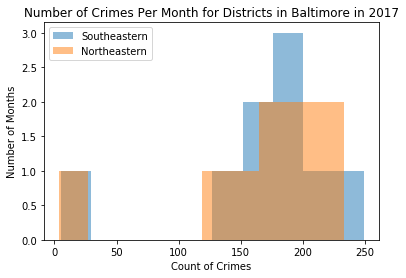

Ttest_indResult(statistic=0.06873227637202775, pvalue=0.9460543818516212)

In [26]:
# Plotting counts of street crimes per district 
plt.hist(street2017_se_month, bins=10, alpha=0.5, label='Southeastern')
plt.hist(street2017_ne_month, bins=10, alpha=0.5, label='Northeastern')
plt.xlabel('Count of Crimes')
plt.ylabel('Number of Months')
plt.legend()
plt.title('Number of Crimes Per Month for Districts in Baltimore in 2017')
plt.show()

# Testing to determine if there is a statistical difference in 
# numbers of crime per month in the two districts
stats.ttest_ind(street2017_se_month, street2017_ne_month)

According to the data, the two districts are statistically similar in crimes by month because the p-value for their differences is 0.946.  This means that the two districts can be compared as districts with similar makeups for our A/B test.  If after the test, this p-value drops below our threshhold for statistical significance, then we can conclude that the experiment made an impact on the number of crimes.

### Rollout Plan
__Copy of Billboards/Electronic Signs:__ We will create billboards and signs in conjunction with auto theft prevention programs in place.  We will also determine how far apart to put the signs (1 sign per mile on main roads).

For example:

[Poster for businesses and buildings](https://pbs.twimg.com/media/DK1XKS0VoAAWTe6.jpg)

[Poster for businesses and buildings (or billboard)](http://i.imgur.com/9DIOyhC.jpg) 

[Text for electronic roadway signs](http://www.ocalapost.com/wp-content/uploads/2015/10/burglaries.jpg)

In [27]:
# Identifying Southeastern district neighborhood with highest crime rates in 2017.
print('Southeastern Neighborhood Crime in 2017:\n', 
      street2017_se[street2017_se['District'] == 'SOUTHEASTERN']['Neighborhood'].value_counts().head(5)) 

Southeastern Neighborhood Crime in 2017:
 Canton                       154
Patterson Park Neighborho    137
Fells Point                  117
McElderry Park               115
Ellwood Park/Monument        106
Name: Neighborhood, dtype: int64


__Rollout Plan:__ We will first target the Canton neighborhood as it is the neighborhood with the highest occurrence of street crimes in the Southeastern District. This will limit the financial strain of the billboards and signs at first before increasing the amount of signs required for the entire district.  We will monitor crime for one month in this neighborhood before assessing the initiative's efficacy and rolling out to the whole district.

Before rolling this out, we will investigate events happening in both districts to ensure that there is not one large event in one that would impact the crime in that district positively or negatively.  We will also test our electronic signs to ensure the quality of message that will be shown.  

__Success Metric:__ T-test for significance of changes between the daily average number of street crimes per month for the test and control districts.  The desired degree of significance is a p-value of less than 0.05.

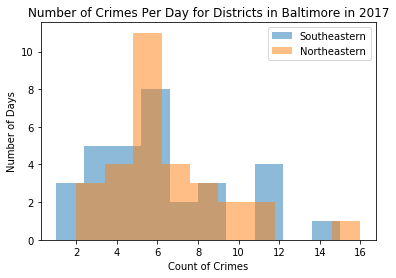

Ttest_indResult(statistic=-0.461368454953136, pvalue=0.646230750490923)

Average Daily Street Crimes in the Southeastern District:
 6.096774193548387
Average Daily Street Crimes in the Northeastern District:
 6.466666666666667

Average Monthly Street Crimes in the Southeastern District:
 169.44444444444446
Average Monthly Street Crimes in the Northeastern District:
 167.22222222222223


In [28]:
# Pulling out number of street crimes per day per district
street2017_se_8 = street2017_se[street2017_se['month']=='08']
street2017_se_daily = street2017_se_8.day.value_counts().sort_index(axis=0, ascending=True)
street2017_ne_8 = street2017_ne[street2017_ne['month']=='08']
street2017_ne_daily = street2017_ne_8.day.value_counts().sort_index(axis=0, ascending=True)

# Plotting counts of street crimes per day for each district district 
plt.hist(street2017_se_daily, bins=10, alpha=0.5, label='Southeastern')
plt.hist(street2017_ne_daily, bins=10, alpha=0.5, label='Northeastern')
plt.xlabel('Count of Crimes')
plt.ylabel('Number of Days')
plt.legend()
plt.title('Number of Crimes Per Day for Districts in Baltimore in 2017')
plt.show()

# Testing to determine if there is a statistical difference in 
# numbers of crime per month in the two districts
print(stats.ttest_ind(street2017_se_daily, street2017_ne_daily))

# Print the average crimes per day
print('\nAverage Daily Street Crimes in the Southeastern District:\n', street2017_se_daily.mean())
print('Average Daily Street Crimes in the Northeastern District:\n', street2017_ne_daily.mean())
print('\nAverage Monthly Street Crimes in the Southeastern District:\n', street2017_se_month.mean())
print('Average Monthly Street Crimes in the Northeastern District:\n', street2017_ne_month.mean())

This shows that the distribution of crimes per day is similar between the two districts because the p-value of the t-test is 0.646.  We can therefore use this statistic as a means to show that crime has decreased.  We can also see the baseline average daily and monthly of street crimes in the districts are approximately 6, and 168, respectfully.

## Evaluation Plan
If, during the first month of the test in Canton, there is a decrease in average daily or monthly street crime by 10%, then roll out signs to the rest of the Southeastern district.  If average daily street crimes decrease significantly in comparison to the Northeastern district (p-value less than 0.05), then implement the campaign across the city.  If average daily street crimes decrease by 10%, but not significantly, observe for two more months before deciding.  If the campaign does not decrease average daily crime in two months, remove signs.